## Load Dataset

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get update -qq

In [ ]:
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

['/usr/share/fonts/truetype/nanum/NanumSquare_acEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquare_acL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic-YetHangul.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf',
 '/usr/share/f

In [ ]:
order = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/Data/order.csv')
course = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/Data/course.csv')
customer = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/Data/customer.csv')
refund = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/Data/refund.csv')

### cf) 파일 DB에 넣는 과정에서, 각 파일 데이터 수정

#### 전체
- 각 테이블 뒤에 _table로 이름 붙임(order의 경우 order_table로 설정하여 order by로 인식되는 것 방지)

#### customer.csv
- user_id 열이 2개였기 때문에, 숫자를 user_id로 놓고 문자열을 가진 열을 user_nickname으로 변경.
- id 열을 customer_id로 변경하여, 각 파일과의 연결성 강화
- 비어있는 값을 가진 열 2개는 삭제

#### refund.csv
- 비어있는 값을 가진 열 1개는 삭제
- 파일을 mariaDB에 넣는 과정에서 course_id가 NULL인 값을 인식을 못하는 오류가 계속 발생하여,
파이썬으로 .fillna(-1)한 뒤 파일 refund_adj.csv로 변경(원본은 남겨놓음) -> foreign_key가 안됨.... 방법 강구

#### course.csv
- id열을 course_id로 변경하여 각 파일과의 연결성 강화
- 비어있는 행들 파일에서 삭제

### Data Schema
1. customer.csv
    - customer_id : 각 고객별 고유 ID(유저에 따라 할당 되는 듯)
    - user_id : 숫자로 된 유저 ID(유저 테이블이 따로 있는 듯. 여기서는 생략)
    - state : 유저 상태(일반, 휴면으로 구분)
    - created_at : 고객 ID 생성 일자
    - updated_at : 고객 ID 업데이트(개인정보 등) 일자
    - user_nickname : 문자열로 된 유저 ID

2. course.csv
    - course_id : 각 강좌별 고유 ID
    - state : 강좌 상태(진행, 숨겨짐으로 구분)
    - created_at : 강좌 생성 일자
    - updated_at : 강좌 업데이트 일자
    - title : 강좌 제목
    - description : 강좌 설명
    - close_at : 강좌 종료 일자
    - total_class_hour : 총 강의 시간
    - keyword : 각 강좌를 설명하는 키워드

3. order.csv
    - order_id : 각 고객별 주문 번호
    - customer_id : 고객 ID(customer의 customer_id와 대응)
    - type : 주문 타입
    - status : 주문 상태(완료, 결제 전 등)
    - name : 주문 강좌 제목
    - created_at : 주문 일시
    - updated_at : 주문 완료 일시
    - list_price : 장바구니 금액
    - sale_price : 결제 금액
    - discount_price : 할인 금액

4. refund.csv
    - order_id : 각 고객별 주문 번호(order의 order_id와 대응)
    - refund_id : 환불 번호
    - refund_status : 환불 진행 상태
    - created_at : 환불 신청 일자
    - updated_at : 환불 업데이트 일자
    - course_id : 강좌 ID(course의 course_id와 대응)
    - amount : 환불 금액

## Q1. Data Extract - SQL


- Q1-1. 4개의 테이블(order, customer, course, refund)을 하나의 테이블로 조인하는 쿼리를 작성해주세요.
- Q1-2. (Order) 2022년 1월 일자별 가장 빠르게 신청된 강의(created_at)와 가장 나중에 신청된 강의를 볼 수 있는 쿼리를 작성해 주세요. (First_Value, Last_value, partition by)
- Q1-3. Order 테이블의 list_price를 일자별(created_at)로 합계한 후, 1일 전 과 1일 후의 매출을 column으로 만들어 주세요. (lead, lag)

## Q2. Data Analysis - Python 2022년 1월 기준

- Q2-1 (Order) 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일은 언제인가요?
(status = COMPLETED 기준)
- Q2-2 (Order) 그리고 그 때의 매출액(list_price)과, 주문 수, 신청자 수, 강의 수는 각각 얼마인가요?
- Q2-3 (Order) 각 강의 별 할인율은 어떻게 될까요?
- Q2-4 (Customer) 회원들은 주로 몇시에 회원 가입을 했나요?
- Q2-5 (Refund) 환불이 가장 많은 강의는 어떤 강의였나요?
- Q2-6 (Customer) 강의를 가장 많이 신청한 고객과 그 금액은 얼마인가요?
- Q2-7 (Order) 주말과 주중의 평균 강의 신청율은 어떻게 다를까요?
- Q2-8 (Course) Keyword 열에서 가장 많이 반복되는 단어는 어떤 단어인가요?
- Q2-9 (Order) 강의 가격(list_price)을 5만원 단위의 도수분포표로 나타내 주세요.
- Q2-10 (Order) 신청이 완료된 강의(complated)와 진행중인 강의(pending), 그리고 취소된 강의(cancelled) 간의 금액(list_price)과 유저의 비중은 각각 어떻게 될까요?

#### Q2-1 (Order) 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일은 언제인가요? (status = COMPLETED 기준)

In [ ]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        27894 non-null  int64  
 1   customer_id     27894 non-null  int64  
 2   type            27894 non-null  object 
 3   status          27894 non-null  object 
 4   course_id       27894 non-null  int64  
 5   name            27894 non-null  object 
 6   created_at      27894 non-null  object 
 7   updated_at      27894 non-null  object 
 8   list_price      27894 non-null  int64  
 9   sale_price      16161 non-null  float64
 10  discount_price  8371 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 2.3+ MB


In [ ]:
order

,order_id,customer_id,type,status,course_id,name,created_at,updated_at,list_price,sale_price,discount_price
0,853323,791388,ORDER,COMPLETED,205080,나의 칼퇴치트키 엑,2022-01-31 23:52,2022-01-31 23:54,156000,136000.0,20000.0
1,853322,560400,ORDER,COMPLETED,205080,나의 칼퇴치트키 엑,2022-01-31 23:51,2022-01-31 23:51,156000,156000.0,NaN
2,853319,455290,ORDER,PENDING,204013,완전정복! 시각디자,2022-01-31 23:40,2022-01-31 23:40,250000,NaN,NaN
3,853317,279538,ORDER,COMPLETED,206742,클라우드를 활용한,2022-01-31 23:39,2022-01-31 23:39,447000,447000.0,NaN
4,853314,790438,ORDER,COMPLETED,205761,한 번에 끝내는 디,2022-01-31 23:30,2022-01-31 23:31,261000,261000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
27889,773401,288777,ORDER,COMPLETED,205648,초격차 패키지 :,2022-01-01 0:23,2022-01-01 0:23,331000,331000.0,NaN
27890,773396,12693,ORDER,COMPLETED,206717,초격차 패키지 :,2022-01-01 0:18,2022-01-01 0:18,212000,212000.0,NaN
27891,773394,753996,ORDER,CANCELLED,206331,한 번에 끝내는 딥,2022-01-01 0:17,2022-01-01 0:17,240000,NaN,NaN
27892,773392,12693,ORDER,PENDING,206717,초격차 패키지 :,2022-01-01 0:13,2022-01-01 0:13,212000,NaN,NaN


In [ ]:
# 현재 created_at과 updated_at이 문자열이므로 날짜 형식으로 변경
order['created_at'] = pd.to_datetime(order['created_at'])
order['updated_at'] = pd.to_datetime(order['created_at'])
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        27894 non-null  int64         
 1   customer_id     27894 non-null  int64         
 2   type            27894 non-null  object        
 3   status          27894 non-null  object        
 4   course_id       27894 non-null  int64         
 5   name            27894 non-null  object        
 6   created_at      27894 non-null  datetime64[ns]
 7   updated_at      27894 non-null  datetime64[ns]
 8   list_price      27894 non-null  int64         
 9   sale_price      16161 non-null  float64       
 10  discount_price  8371 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 2.3+ MB


In [ ]:
# 일자까지만 나오도록 하는 열 작성
order['created_at_date'] = order['created_at'].dt.date
order['updated_at_date'] = order['updated_at'].dt.date

In [ ]:
# 각 price 다루기 전 데이터 정합성 체크 -> 만족
order_consistency = order.copy()

order_consistency['discount_price'].fillna(0, inplace=True)

order_consistency['sale_price'].fillna(order_consistency['list_price'] - order_consistency['discount_price'], inplace=True)

order_consistency['check'] = order_consistency['list_price'] - order_consistency['discount_price'] == order_consistency['sale_price']

order_consistency[order_consistency['check'] == False]

,order_id,customer_id,type,status,course_id,name,created_at,updated_at,list_price,sale_price,discount_price,created_at_date,updated_at_date,check


In [ ]:
# 계산, 가장 매출이 적은 3일과 가장 매출이 많은 3일
q2_1 = order[order['status'] == 'COMPLETED'].groupby('created_at_date')['list_price'].sum().sort_values()
print(q2_1.head(3))
print('\n')
print(q2_1.tail(3))

created_at_date
2022-01-22    37842240
2022-01-01    49548000
2022-01-23    54444580
Name: list_price, dtype: int64


created_at_date
2022-01-05    245899040
2022-01-09    261886930
2022-01-03    284255000
Name: list_price, dtype: int64


#### Q2-2 (Order) 그리고 그 때의 매출액(list_price)과, 주문 수, 신청자 수, 강의 수는 각각 얼마인가요?

In [ ]:
'''
여기서 궁금한 점이 있습니다. 강의 때도 질문 드리겠지만...
매출이 list_price를 합치는 건지 궁금합니다. 제가 생각하기에는 list_price는 장바구니 금액이고,
거기서 discount_price로 할인 받은 금액인 최종 결제 금액 sale_price를 통해 구한게 매출로 생각했거든요.
sale_price랑 discount_price에 nan값이 있긴하지만 이 부분은 채워주면 되는 부분이기에, list_price로 구하는 이유가 궁금합니다.
여기 문제에서는 요구사항대로 일단 구했으나, 질문 드립니다!
'''
q2_2_1 = order[order['status'] == 'COMPLETED'].groupby('created_at_date')['list_price'].sum().sort_index()
q2_2_2 = order[order['status'] == 'COMPLETED'].groupby('created_at_date').agg({
    'order_id': pd.Series.nunique,
    'customer_id': pd.Series.nunique,
    'course_id': pd.Series.nunique
}).sort_index()
q2_2 = pd.merge(q2_2_1, q2_2_2, on = 'created_at_date', how='inner').sort_values(by='list_price')
print(q2_2.head(3))
print('\n')
print(q2_2.tail(3))

                 list_price  order_id  customer_id  course_id
created_at_date                                              
2022-01-22         37842240       170          143        105
2022-01-01         49548000       234          220        107
2022-01-23         54444580       256          229        107


                 list_price  order_id  customer_id  course_id
created_at_date                                              
2022-01-05        245899040      1114         1014        208
2022-01-09        261886930      1190         1055        204
2022-01-03        284255000      1281         1186        213


####Q2-3 (Order) 각 강의 별 할인율은 어떻게 될까요?

In [ ]:
# 뇌 성장과 정서사회 강의의 평균 할인율이 가장 높았으며, C# 강의가 가장 낮았음.
order['discount_rate'] = order['list_price'] / order['discount_price']
q2_3 = order[order['discount_rate'].notna()].groupby('name')['discount_rate'].mean().sort_values(ascending=False)
q2_3

name
뇌 성장과 정서사회    20.001577
현직 VC가 알려주    19.000000
              12.100000
배곡파 작가의 실사    11.430159
sudo : CTO    10.000000
                ...    
누적 조회수 12억     1.897411
A/B 테스트 탑재     1.688544
3단계로 끝내는 직     1.509094
젊은 VC 심사역들     1.247863
C#으로 하는 인공     1.241965
Name: discount_rate, Length: 189, dtype: float64

####Q2-4 (Customer) 회원들은 주로 몇시에 회원 가입을 했나요?

In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          19684 non-null  float64
 1   user_id     19684 non-null  float64
 2   state       19684 non-null  object 
 3   created_at  19684 non-null  object 
 4   updated_at  19684 non-null  object 
 5   user_id.1   19684 non-null  object 
 6   Unnamed: 6  0 non-null      float64
 7   Unnamed: 7  0 non-null      float64
dtypes: float64(4), object(4)
memory usage: 1.7+ MB


In [ ]:
# 열 이름 수정
customer.rename(columns={'id' : 'customer_id', 'user_id.1' : 'user_nickname'}, inplace=True)
customer = customer[['customer_id', 'user_id', 'state', 'created_at', 'updated_at', 'user_nickname']]
customer = customer[customer['customer_id'].notna()]
customer

,customer_id,user_id,state,created_at,updated_at,user_nickname
0,23139.0,12.0,NORMAL,2019-09-23 23:21,2023-05-01 6:20,iolo
1,23179.0,18.0,NORMAL,2019-09-24 2:05,2019-09-24 2:05,smki
2,18948.0,25.0,NORMAL,2019-09-09 8:27,2023-01-25 7:17,haed
3,17531.0,424.0,NORMAL,2019-09-07 10:10,2023-10-19 1:13,gkaw
4,23028.0,1103.0,NORMAL,2019-09-23 8:45,2022-11-21 20:39,kang
...,...,...,...,...,...,...
19679,791375.0,781335.0,NORMAL,2022-01-31 22:38,2022-01-31 22:46,dung
19680,791379.0,781339.0,NORMAL,2022-01-31 23:12,2023-04-26 7:33,akul
19681,791382.0,781342.0,NORMAL,2022-01-31 23:19,2023-04-26 7:33,wwdf
19682,791388.0,781348.0,NORMAL,2022-01-31 23:39,2022-11-29 13:35,dusr


In [ ]:
# order와 마찬가지로 datetime으로 변경, 일자 및 시간 칼럼 생성
customer['created_at'] = pd.to_datetime(customer['created_at'])
customer['updated_at'] = pd.to_datetime(customer['updated_at'])
customer['created_at_date'] = customer['created_at'].dt.date
customer['updated_at_date'] = customer['created_at'].dt.date
customer['created_at_hour'] = customer['created_at'].dt.hour
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19684 entries, 0 to 19683
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      19684 non-null  float64       
 1   user_id          19684 non-null  float64       
 2   state            19684 non-null  object        
 3   created_at       19684 non-null  datetime64[ns]
 4   updated_at       19684 non-null  datetime64[ns]
 5   user_nickname    19684 non-null  object        
 6   created_at_date  19684 non-null  object        
 7   updated_at_date  19684 non-null  object        
 8   created_at_hour  19684 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 1.5+ MB


In [ ]:
# 고객들은 13시에 가장 많이 가입했으며, 주로 점심시간에 많이 가입함. 또한 오전시간에도 많이 가입하는 것을 보여줌.
# 반면 오후, 저녁 시간에는 가입 인원이 적음을 확인.
q2_4 = customer.groupby('created_at_hour')['customer_id'].count().sort_values(ascending=False).sort_index()
q2_4 = pd.DataFrame(q2_4)
q2_4

,customer_id
created_at_hour,
0,785
1,1077
2,1086
3,881
4,1086
5,1161
6,1195
7,1197
8,1128


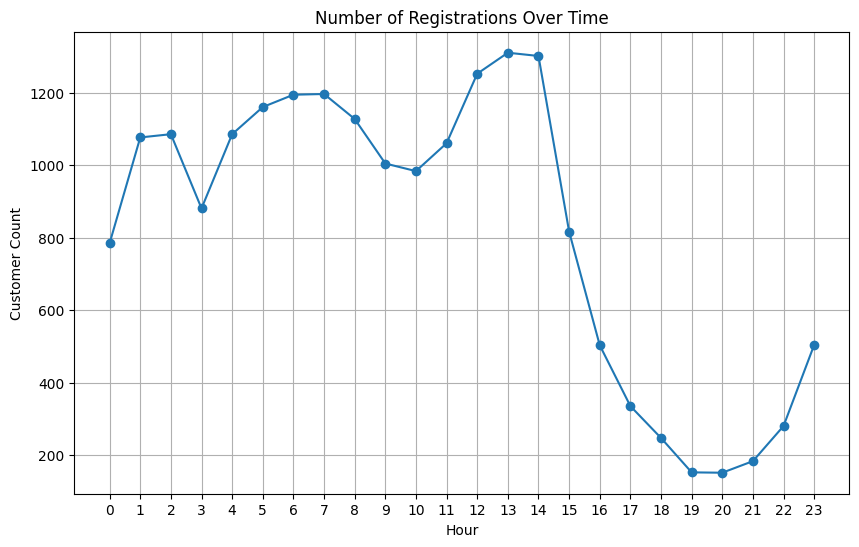

In [ ]:
# 시각화를 해보면, 14시 이후 가입 신청 인원이 급격히 줄어들다가 20시 이후 다시 높아진다.
created_at_hour = q2_4.index
customer_count = q2_4['customer_id']

plt.figure(figsize=(10, 6))
plt.plot(created_at_hour, customer_count, marker='o', linestyle='-')
plt.title('Number of Registrations Over Time')
plt.xlabel('Hour')
plt.ylabel('Customer Count')
plt.grid(True)

plt.xticks(created_at_hour)

plt.show()

####Q2-5 (Refund) 환불이 가장 많은 강의는 어떤 강의였나요?

In [ ]:
# 데이터 수정
refund = refund.drop('Unnamed: 7', axis=1)
refund = refund[refund['order_id'].notna()]
refund

,order_id,refund_id,refund_status,created_at,updated_at,course_id,amount
0,773436.0,45470.0,COMPLETED,2022-01-06 9:46,2022-01-06 9:46,206185.0,-241000.0
1,773451.0,45382.0,COMPLETED,2022-01-06 5:24,2022-01-06 5:24,203146.0,-210000.0
2,773507.0,44996.0,COMPLETED,2022-01-03 6:23,2022-01-03 6:23,205949.0,-132205.0
3,773520.0,46333.0,COMPLETED,2022-01-17 4:41,2022-01-17 4:41,203782.0,-120666.0
4,773529.0,45256.0,COMPLETED,2022-01-05 8:59,2022-01-05 8:59,206060.0,-212000.0
...,...,...,...,...,...,...,...
1047,844971.0,47185.0,COMPLETED,2022-01-28 4:00,2022-01-28 4:00,206411.0,-131000.0
1048,845224.0,47205.0,COMPLETED,2022-01-28 5:10,2022-01-28 5:10,208383.0,-203000.0
1049,845477.0,47226.0,COMPLETED,2022-01-28 6:19,2022-01-28 6:19,207930.0,-189000.0
1050,845510.0,47231.0,COMPLETED,2022-01-28 6:40,2022-01-28 6:40,207930.0,-189000.0


In [ ]:
# 마찬가지로 일자 datetime으로 변경
refund['created_at'] = pd.to_datetime(refund['created_at'])
refund['updated_at'] = pd.to_datetime(refund['updated_at'])
refund.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 0 to 1051
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       1052 non-null   float64       
 1   refund_id      1052 non-null   float64       
 2   refund_status  1052 non-null   object        
 3   created_at     1052 non-null   datetime64[ns]
 4   updated_at     1052 non-null   datetime64[ns]
 5   course_id      1008 non-null   float64       
 6   amount         1052 non-null   float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 65.8+ KB


In [ ]:
# course와의 병합 위해 course도 수정
course = course[course['id'].notna()]
course.rename(columns={'id' : 'course_id'}, inplace=True)
course

,course_id,state,created_at,updated_at,title,description,close_at,total_class_hours,keywords
0,211503.0,ONGOING,2021-08-19 9:09,2022-06-15 4:28,뇌 성장과 정서사회,소아정신과 전문의,NaN,8.0,NaN
1,209970.0,ENDED,2022-01-25 5:39,2023-01-25 0:01,(B2B) 와이즈셀,NaN,2023-01-24 15:00,NaN,NaN
2,209948.0,ENDED,2022-01-25 4:18,2023-01-26 0:01,(B2B) 크몽 온,NaN,2023-01-25 15:00,NaN,NaN
3,209939.0,ONGOING,2022-01-24 6:24,2022-11-16 2:19,(B2B) K-Di,NaN,NaN,19.0,NaN
4,209938.0,ONGOING,2022-01-24 5:57,2022-11-16 2:39,K-Digital,NaN,NaN,23.0,NaN
...,...,...,...,...,...,...,...,...,...
334,201547.0,HIDDEN,2019-09-17 8:43,2023-06-01 1:23,구글 애널리틱스 올,"데이터, 제대로 보",NaN,20.0,"GA,데이터분석,마케팅,데이터마케팅"
335,201435.0,HIDDEN,2019-08-21 2:40,2022-12-27 7:15,알고리즘 / 기술면,오직 개발자 취업을,NaN,42.0,"자료구조,평생소장,프로그래밍, 개발자 커리어"
336,201408.0,HIDDEN,2019-08-13 4:39,2022-11-02 1:45,엑셀 실무 마스터,"20시간 분량, 대",NaN,22.0,"평생소장,엑셀"
337,200399.0,HIDDEN,2019-03-22 9:22,2023-09-01 1:07,리더를 위한 HR/,성과내는 조직을 만,NaN,14.0,"조직문화,업무 생산성,리더십"


In [ ]:
# course_id 203720, 한 번에 끝내는 프~ 강의의 환불이 31번으로 가장 많음.(아마 프로그래밍인듯)
q2_5 = refund.groupby('course_id')['refund_id'].count().sort_values(ascending=False)
q2_5 = pd.DataFrame(q2_5).reset_index()
q2_5.rename(columns={'refund_id' : 'refund_count'}, inplace=True)
q2_5 = pd.merge(q2_5, course, on='course_id', how='left')[['course_id', 'title', 'refund_count']]
q2_5

,course_id,title,refund_count
0,203720.0,한 번에 끝내는 프,31
1,207513.0,블렌더로 만드는 동,24
2,208856.0,30개 프로젝트로,20
3,205761.0,한 번에 끝내는 디,18
4,206060.0,한 번에 끝내는 컴,17
...,...,...,...
210,205450.0,탄탄한 Animat,1
211,205440.0,한 번에 끝내는 포,1
212,202611.0,모델 성능 개선으로,1
213,205222.0,The RED :,1


In [ ]:
# 전체 강의의 평균 환불 횟수 : 4.7회
q2_5['refund_count'].mean()

4.688372093023256

In [ ]:
# '한 번에 끝내는' 강의의 평균 환불 횟수 : 9.2회
# '한 번에 끝내는' 강의의 평균 환불 횟수가 전체 평균에 비해 4.5회 많음.
q2_5[q2_5['title'].str.contains('한 번에 끝내는')]['refund_count'].mean()

9.208333333333334

In [ ]:
# 'The RED' 강의의 평균 환불 횟수 : 2.9회
# 'The RED' 강의의 평균 환불 횟수는 전체 평균에 비해 1.8회 적음.
q2_5[q2_5['title'].str.contains('The RED')]['refund_count'].mean()

2.9523809523809526

#### Q2-6 (Customer) 강의를 가장 많이 신청한 고객과 그 금액은 얼마인가요?

In [ ]:
# customer와 order merge하여 계산
# 116416고객이 가장 많이 계산하였으나, 억 단위가 넘어간다는 점에서 이상치일 확률이 높아보임.
# 그 외 list_price 상으로는 786150, sale_price 상으로는 777103이 많이 강의를 신청 및 구매.
cus_order = pd.merge(order, customer, on = 'customer_id', how='left')
q2_6 = cus_order.groupby('customer_id')[['list_price', 'sale_price']].sum().sort_values(by='list_price', ascending=False)
q2_6

,list_price,sale_price
customer_id,,
116416,271527136,71121784.0
786150,11400000,950000.0
777103,8400000,8400000.0
27041,8379000,441000.0
41519,7831000,5675000.0
...,...,...
753629,30000,30000.0
771664,22200,0.0
784001,22200,22200.0


In [ ]:
q2_6_1 = cus_order.groupby('customer_id')[['list_price', 'sale_price']].sum().sort_values(by='sale_price', ascending=False)
q2_6_1

,list_price,sale_price
customer_id,,
116416,271527136,71121784.0
777103,8400000,8400000.0
41519,7831000,5675000.0
785090,5280000,5280000.0
779700,5152000,5052000.0
...,...,...
784752,504000,0.0
784651,205000,0.0
738724,334000,0.0


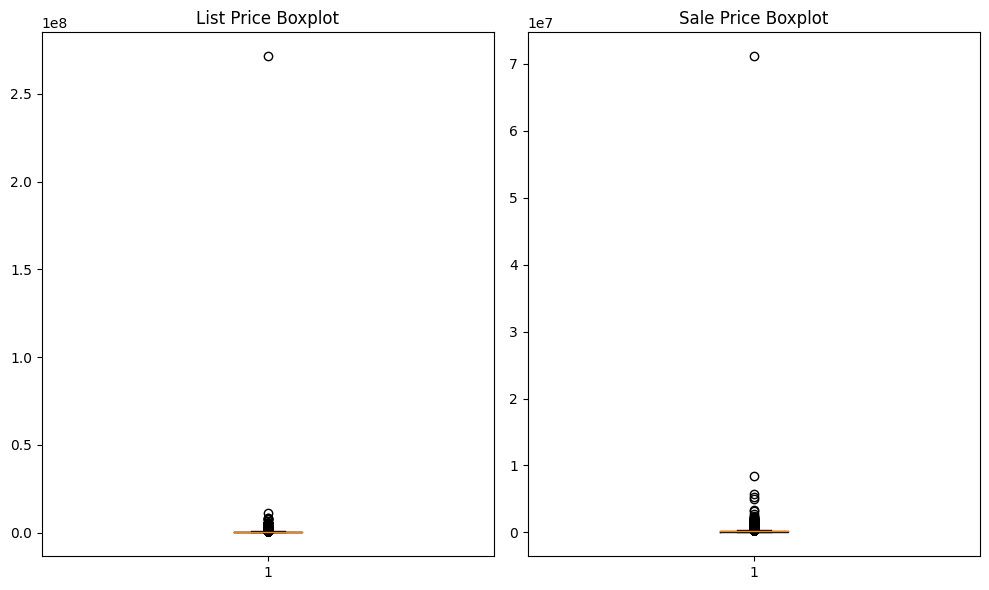

In [ ]:
# 이상치 확인을 위해 boxplot 그려보기.
# 이상치가 조금 분포해 있으나, 맨 위에 있는 116416은 이상치가 확실해보임.
# 그에 따라 list_price 상으로는 786150, sale_price 상으로는 777103이 많이 강의를 신청 및 구매했다고 볼 수 있음.

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(q2_6['list_price'])
plt.title('List Price Boxplot')

plt.subplot(1, 2, 2)
plt.boxplot(q2_6['sale_price'])
plt.title('Sale Price Boxplot')

plt.tight_layout()
plt.show()

#### Q2-7 (Order) 주말과 주중의 평균 강의 신청율은 어떻게 다를까요?

In [ ]:
# 주중에는 강의 신청율이 70.66%로 대부분을 차지하지만, 주말에는 29.33%로 신청을 덜 하는 경향이 있음.
# 다만 이것은 주중의 날짜가 많기 때문에 나오는 현상일 수 있어, 요일별 강의 신청율을 살펴볼 필요가 있음.
order['created_weekday'] = order['created_at'].dt.weekday
order['created_weekend'] = order['created_weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

q2_7 = order['created_weekend'].value_counts(normalize=True)
q2_7

Weekday    0.706639
Weekend    0.293361
Name: created_weekend, dtype: float64

In [ ]:
weekday_counts = order['created_weekday'].value_counts(normalize=True).sort_index()

weekday_percentages = weekday_counts * 100

print(weekday_percentages)

0    18.115007
1    11.823331
2    14.106976
3    12.117301
4    14.501326
5    10.267441
6    19.068617
Name: created_weekday, dtype: float64


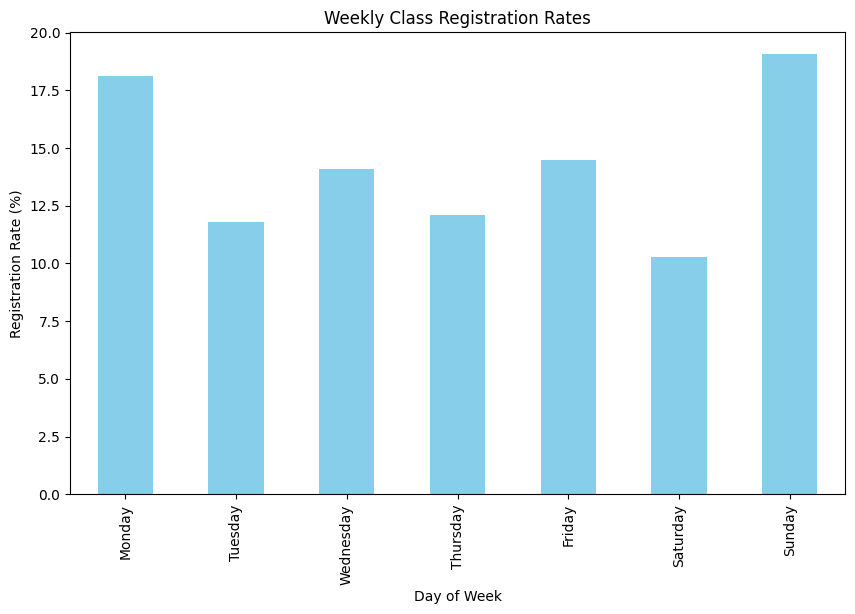

In [ ]:
# 신청 비율은 일요일에 가장 높으며, 그 다음이 월요일로 높음
# 가장 낮은 신청 비율은 토요일에 보임.
days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

weekday_percentages = weekday_percentages.rename(index=days_of_week)

weekday_percentages = weekday_percentages.round(2)

plt.figure(figsize=(10, 6))
weekday_percentages.plot(kind='bar', color='skyblue')

plt.title('Weekly Class Registration Rates')
plt.xlabel('Day of Week')
plt.ylabel('Registration Rate (%)')

plt.show()

#### Q2-8 (Course) Keyword 열에서 가장 많이 반복되는 단어는 어떤 단어인가요?

In [ ]:
# 평생소장이라는 단어가 가장 많이 반복되며, 그 외 데이터사이언스, 프로그래밍, 부동산, 딥러닝 순으로 나옴.
# 사람들의 관심도 및 현재 트렌드에 따라 강의가 개설되는 것으로 보임.
splitted_keywords = course['keywords'].str.split(',')

exploded_keywords = splitted_keywords.explode()

q2_8 = exploded_keywords.value_counts()

print(q2_8)

평생소장       64
데이터사이언스    53
프로그래밍      51
부동산        29
딥러닝        28
           ..
의존성         1
사이드이펙트      1
비동기         1
비동기처리       1
금융커리어       1
Name: keywords, Length: 1606, dtype: int64


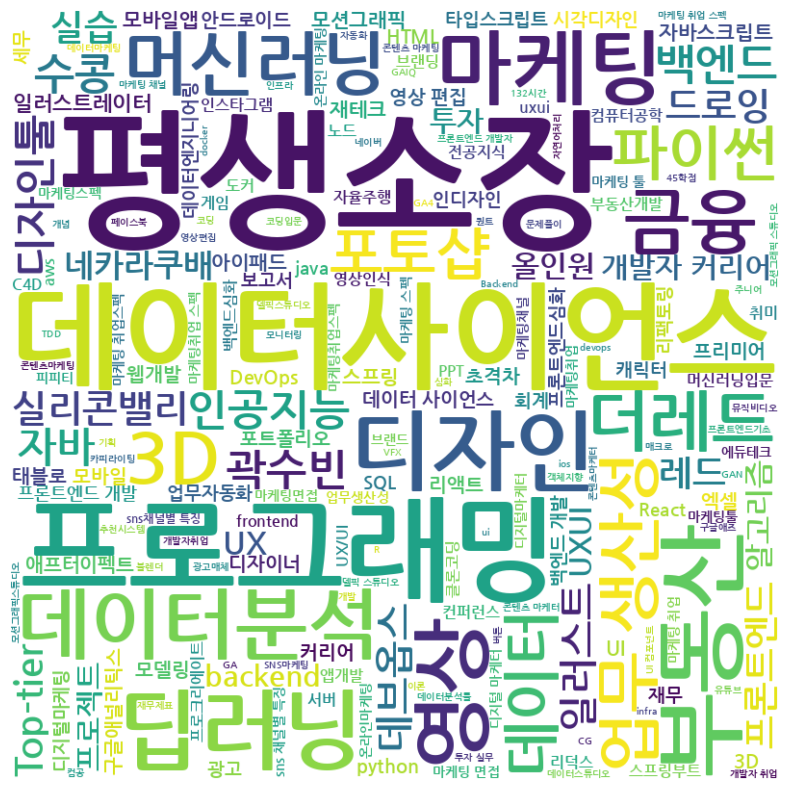

In [ ]:
# 워드클라우드로 시각화해보기.
from wordcloud import WordCloud

wordcloud = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
                      background_color='white',
                      width=800, height=800).generate_from_frequencies(q2_8)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Q2-9 (Order) 강의 가격(list_price)을 5만원 단위의 도수분포표로 나타내 주세요.

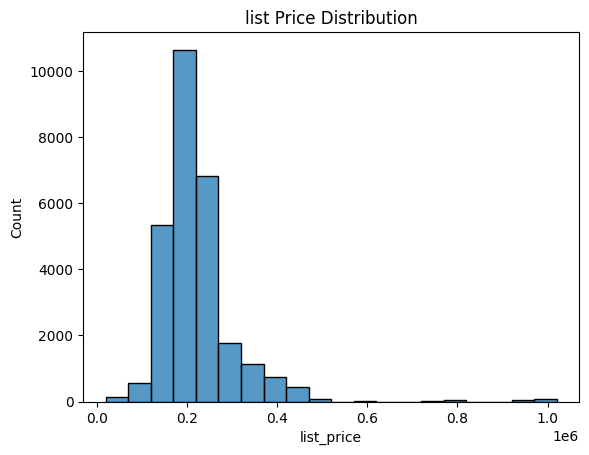

In [ ]:
# 일정 금액 이상의 list_price는 맨 끝 값에 포함.
# 20만원대의 주문 수가 가장 많음.
q2_9 = order['list_price'].apply(lambda x: min(x, 1000000))

min_price = q2_9.min()

bins = np.arange(min_price, 1000000 + 50000, 50000)

sns.histplot(q2_9, bins=bins)

plt.title('list Price Distribution')

plt.show()

#### Q2-10 (Order) 신청이 완료된 강의(complated)와 진행중인 강의(pending), 그리고 취소된 강의(cancelled) 간의 금액(list_price)과 유저의 비중은 각각 어떻게 될까요?

In [ ]:
# 신청 완료 강의의 list_price 비중은 56%이고 유저 비중은 92%이다.
# 취소한 강의의 list_price 비중은 25%, 유저 비중은 29%이다.
# 또한 신청 진행 중인 강의의 list_price 비중은 18%, 유저 비중은 19% 이다.
# 유저 비중이 100% 이상인 이유는 유저가 각 강의를 중복해서 신청할 수 있기 때문.

q2_10 = order.groupby('status').agg({
    'list_price': 'sum',
    'customer_id': pd.Series.nunique
})

total_list_price = order['list_price'].sum()
total_unique_customers = order['customer_id'].nunique()

q2_10['list_price_pct'] = q2_10['list_price'] / total_list_price * 100
q2_10['customer_id_pct'] = q2_10['customer_id'] / total_unique_customers * 100
print(q2_10)

           list_price  customer_id  list_price_pct  customer_id_pct
status                                                             
CANCELLED  1655615498         4164       25.452319        29.076182
COMPLETED  3643955954        13262       56.019728        92.605265
PENDING    1205201204         2762       18.527953        19.286363


## Q3. Data Visualization - Excel, Tableau, Power BI, python(matplolib, seaborn)
Q2에 대한 답을 하면서 적절하다고 생각하는 차트를 만들어주세요.

### 위에서 시각화는 어느정도 완료하였으며, Tableau에서는 조금 더 심화적인 관점의 대시보드를 작성.

### 1. Metric Hierarchy Dashboard : https://public.tableau.com/app/profile/seunghoon.choi/viz/FastcampusMetricHierarchyDashboard/1
- Order.csv와 Refund.csv파일을 가지고 Metric Hierarchy를 통해 Order / ARPPU를 1주일 단위로 세분화.
- 1월 2주차의 경우 1주차에 비해 전체 매출은 11%, 주문 횟수는 27% 줄었음. 하지만 ARPPU는 29% 늘음. 특히 고객이 1번 주문할 때의 평균 금액이 25% 늘었음.
- 1월 3주차의 경우 2주차에 비해 전체 매출은 18%, 주문 횟수는 26% 줄었음. 하지만 마찬가지로 ARPPU는 6% 늘음. 고객이 1번 주문할 때의 평균 금액 또한 12% 늘음.
- 1월 4주차의 경우 3주차에 비해 전체 매출이 23%, 주문 횟수가 22% 줄었으며 ARPPU 또한 3% 줄음. 다만 고객이 1번 주문할 때 평균 금액은 1% 늘었으며 환불 금액이 전주 대비 32% 줄어든 것이 눈에 띔.
- 즉 1월 달에는 주마다 전체 매출 및 주문 횟수는 지속적으로 감소, 하지만 고객의 평균 주문 금액은 상승하는 경향이 있었음. ARPPU는 3주차까지 상승하다 4주차에 감소.

### 2. User Event Analytic Dashboard : https://public.tableau.com/app/profile/seunghoon.choi/viz/FastcampusUserEventAnalyticsChartDashboard/ChartDashboard
- 각 데이터를 해당 대시보드에 맞게 Python으로 전처리 후 작성
- Event Revenue는 Sale_price, Price는 list_price
- Sign Up의 경우 2022-01-31까지 customer.created_at을 필터링 한 후, Unique User를 통해 날짜별, 주별, 월별 가입자 수를 볼 수 있음.
- Add to Cart 부터는 주문 관련 2022년 1월 1달 정보를 일별, 주별로 볼 수 있음.
    - Add to Cart는 Pending 상태의 주문 관련 정보를 볼 수 있음
    - Drop From Cart는 Canceled 상태의 주문 관련 정보를 볼 수 있음
    - Purchase는 Completed 상태의 주문 관련 정보를 볼 수 있음.
    - Refund는 Refund.csv에 있는 환불된 상태의 주문 관련 정보를 볼 수 있음.
- 1.18일의 경우 Add to Cart, Drop From Cart, Purchase 모두 다른 날에비해 Peak를 찍은 경우가 있음. 대형 이벤트를 한 날로 보임.
- 고객 수의 경우 지속적으로 줄어들다 4주차부터 다시 회복세를 보임.
- 평균 구매 횟수는 1.22일이 가장 높았음.


## Q4. Analytics Report
데이터를 보면서 데이터 분석가로서 찾아낸 인사이트를 공유해주세요. 데이터 분석가마다 보는 관점이 다르고 나타내는 방법도 다양합니다. 데이터 분석을 잘 모르는 비즈니스 유저에게 본인의 분석 결과를 설명한다고 가정하고 어떤 제안을 할 수 있는지 생각해 보면 좋을 것 같습니다.

## EDA 결과

1. Metric Hierarchy 대시보드 확인 결과 1월의 주차마다 매출 및 주문 횟수가 지속적으로 줄고 있음. 다만 고객 평균 주문 금액은 상승, ARPPU는 3주차까지 상승. / 주문 취소 횟수 자체는 주마다 감소하고 있으나 주문 횟수가 줄어듬의 영향이 크며, 주문 취소율은 2주차에 24.51%로 정점을 찍고 유지하는 경향(취소율 1주차 : 22.65 / 2주차 : 24.51 / 3주차 : 24.44 / 4주차 : 24.32)

2. 1월에 가장 매출이 낮았던 날은 22일, 1일, 23일 순이며, 가장 높았던 날은 5일, 9일, 3일임.
신정날과 22(토) / 23(일)이 낮은 반면 5(수) / 9(일) / 3(월)이 높은데,
2022년 1월 1, 2일, 22, 23일은 이벤트가 끝나고 다음 이벤트를 준비하는 기간이며
매출이 높았던 날은 이벤트가 진행되는 기간으로 보임. 신규 강의 런칭 및 고객 수, 주문 수의 차이가 그를 뒷받침.
이벤트가 진행되지 않는 날 매출을 늘릴 만한 방안을 강구할 필요가 있음.

3. 신규 가입 시간이 점심에 정점을 찍고 저녁까지 급격하게 내려감.
그 이후 다시 올라가는데, 광고를 한다면 가입이 급감하는 해당 시간대에 광고나 이벤트를 하면 가입 수가 늘어날 것으로 예상.

4. ‘한 번에 끝내는’ 강의의 refund 횟수가 많은 편임.   

5. list_price 상으로는 786150 회원이 가장 많은 금액을 주문(11,400,000)했으며 sale_price 상으로는 777103 회원이 가장 많은 금액을 주문(8,400,000)함. 2억 이상 주문한 고객이 있는데 이상치로 판단해 제거.

6. 주중에는 70%, 주말에는 30% 정도 강의 신청함. 다만 요일 별로는 일, 월요일의 강의 신청율이 높으며 토요일의 강의 신청율이 낮음. 강의 신청율이 낮은 날 이벤트를 해도 괜찮을 듯 함.

7. 대부분 20만원대에서 list_price가 분포되어있음. 1,000,000원 이상 구매한 고객은 우수회원으로서 이벤트를 해도 좋을 듯 함.

8. 신청 완료한 강의의 고객 비율은 92%지만, list_price 비중으로는 56%밖에 안되며 cancel되는 강의의 list_price 비중이 25%임. cancel되는 강의의 특성을 살펴볼 필요가 있음.

### 6번에서 언급했던 이벤트를 하기에 앞서, 우수회원을 다시 정의 : RFM 분석

In [ ]:
order

,order_id,customer_id,type,status,course_id,name,created_at,updated_at,list_price,sale_price,discount_price,created_at_date,updated_at_date,discount_rate,created_weekday,created_weekend
0,853323,791388,ORDER,COMPLETED,205080,나의 칼퇴치트키 엑,2022-01-31 23:52:00,2022-01-31 23:52:00,156000,136000.0,20000.0,2022-01-31,2022-01-31,7.8,0,Weekday
1,853322,560400,ORDER,COMPLETED,205080,나의 칼퇴치트키 엑,2022-01-31 23:51:00,2022-01-31 23:51:00,156000,156000.0,NaN,2022-01-31,2022-01-31,NaN,0,Weekday
2,853319,455290,ORDER,PENDING,204013,완전정복! 시각디자,2022-01-31 23:40:00,2022-01-31 23:40:00,250000,NaN,NaN,2022-01-31,2022-01-31,NaN,0,Weekday
3,853317,279538,ORDER,COMPLETED,206742,클라우드를 활용한,2022-01-31 23:39:00,2022-01-31 23:39:00,447000,447000.0,NaN,2022-01-31,2022-01-31,NaN,0,Weekday
4,853314,790438,ORDER,COMPLETED,205761,한 번에 끝내는 디,2022-01-31 23:30:00,2022-01-31 23:30:00,261000,261000.0,NaN,2022-01-31,2022-01-31,NaN,0,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27889,773401,288777,ORDER,COMPLETED,205648,초격차 패키지 :,2022-01-01 00:23:00,2022-01-01 00:23:00,331000,331000.0,NaN,2022-01-01,2022-01-01,NaN,5,Weekend
27890,773396,12693,ORDER,COMPLETED,206717,초격차 패키지 :,2022-01-01 00:18:00,2022-01-01 00:18:00,212000,212000.0,NaN,2022-01-01,2022-01-01,NaN,5,Weekend
27891,773394,753996,ORDER,CANCELLED,206331,한 번에 끝내는 딥,2022-01-01 00:17:00,2022-01-01 00:17:00,240000,NaN,NaN,2022-01-01,2022-01-01,NaN,5,Weekend
27892,773392,12693,ORDER,PENDING,206717,초격차 패키지 :,2022-01-01 00:13:00,2022-01-01 00:13:00,212000,NaN,NaN,2022-01-01,2022-01-01,NaN,5,Weekend


In [ ]:
rfm_order = order[order['status'] == 'COMPLETED'].groupby('customer_id').agg({
    'created_at': lambda x: (pd.to_datetime('2022-02-01') - x.max()).days,
    'sale_price': lambda x: x.sum(),
    'order_id': lambda x: x.nunique()
})

rfm_order.columns = ['recency', 'monetary', 'frequency']
print(rfm_order.shape)
rfm_order.head()

(13262, 3)


,recency,monetary,frequency
customer_id,,,
136,1,186000.0,1
203,1,249000.0,1
212,28,182000.0,1
339,26,532000.0,3
381,26,141000.0,1


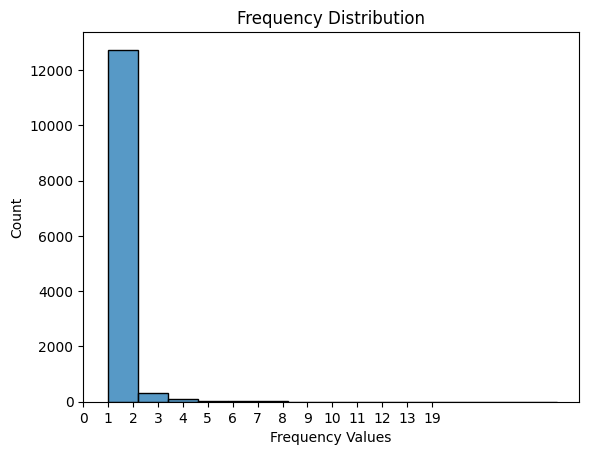

In [ ]:
# frequency를 살펴본 결과 1과 2에 집중
sns.histplot(rfm_order['frequency'])

sorted_unique_values = sorted(rfm_order['frequency'].unique().tolist() + [0])
plt.xticks(ticks=range(len(sorted_unique_values)), labels=sorted_unique_values)

plt.title('Frequency Distribution')
plt.xlabel('Frequency Values')
plt.ylabel('Count')

plt.show()

In [ ]:
print(sorted(rfm_order['frequency'].unique().tolist()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19]


In [ ]:
# 상위 90%까지가 2번 구매 고객
rfm_order['frequency'].quantile(90/100)

2.0

In [ ]:
# 90~99% 고객 까지는 2 ~ 4회 구매 고객
rfm_order['frequency'].quantile(99/100)

4.0

In [ ]:
# RFM 기준 산정
# recency의 경우 데이터 기간이 1달이기 때문에, 3개의 구간으로만 나눔
# monetary의 경우 구간이 조금 크며, 3으로만 나눌경우 대부분의 데이터가 분포한 20만원대에 많이 걸치므로 조금 더 세분화하기위해 4로 나눔
# frequency의 경우 아래에도 나오지만 상위 90%부터 2번 구매한 유저, 99%까지가 4번 구매한 유저여서 이렇게 나눔

rfm_order['recency_score'] = pd.qcut(rfm_order['recency'], 3, labels=[3, 2, 1])
rfm_order['monetary_score'] = pd.qcut(rfm_order['monetary'], 4, labels=[1, 2, 3, 4])
rfm_order['frequency_score'] = pd.cut(rfm_order['frequency'], bins=[-np.inf, rfm_order['frequency'].quantile(90/100), rfm_order['frequency'].quantile(99/100), np.inf], labels=[1, 2, 3], duplicates='drop')

rfm_order['rfm_index'] = rfm_order['recency_score'].astype(str) + rfm_order['frequency_score'].astype(str) + rfm_order['monetary_score'].astype(str)
rfm_order.reset_index(inplace=True)
rfm_order.head(10)

,customer_id,recency,monetary,frequency,recency_score,monetary_score,frequency_score,rfm_index
0,136,1,186000.0,1,3,3,1,313
1,203,1,249000.0,1,3,3,1,313
2,212,28,182000.0,1,1,2,1,112
3,339,26,532000.0,3,1,4,2,124
4,381,26,141000.0,1,1,2,1,112
5,438,20,149000.0,1,2,2,1,212
6,514,10,254000.0,1,3,4,1,314
7,610,15,309000.0,1,2,4,1,214
8,614,25,159000.0,1,1,2,1,112
9,663,24,199000.0,1,2,3,1,213


In [ ]:
print("Monetary 스코어 구간")
print(rfm_order.groupby(['monetary_score'])['monetary'].min().reset_index())

Monetary 스코어 구간
  monetary_score  monetary
0              1    1000.0
1              2  137200.0
2              3  184000.0
3              4  249200.0


In [ ]:
print("Recency 스코어 구간")
print(rfm_order.groupby(['recency_score'])['recency'].min().reset_index())

Recency 스코어 구간
  recency_score  recency
0             3        0
1             2       14
2             1       25


In [ ]:
print("Frequency 스코어 구간")
print(rfm_order.groupby(['frequency_score'])['frequency'].min().reset_index())

Frequency 스코어 구간
  frequency_score  frequency
0               1          1
1               2          3
2               3          5


In [ ]:
## 각 score별 고객 수 확인
rfm_index = rfm_order.groupby('rfm_index')['customer_id'].nunique().reset_index().rename({'customer_id':'customer_count'}, axis=1)
rfm_index

,rfm_index,customer_count
0,111,1551
1,112,762
2,113,771
3,114,469
4,121,6
5,123,3
6,124,39
7,131,3
8,132,1
9,134,5


위에서 나눈 score에 따라 고객을 아래 표와 같이 segment함.  
(기간이 1달 밖에 안되기 때문에 Recency를 세부적으로 나누기가 조금 어려웠음.  
또한 기간이 짧아 이탈 고객이라고 하지 않고 이탈 우려 고객이라고 함.)

<img width="853" alt="스크린샷 2024-02-06 오후 2 38 08" src="https://github.com/hoon-bari/Recommender_systems/assets/121400054/34ed5a05-7cc9-4a59-a1b4-03dfe1a1e35b">

In [ ]:
def categorize_customer(score):
    if score in ['324', '334']:
        return '1_VIP고객'
    elif score in ['223', '224', '233', '234', '323', '333']:
        return '2_충성고객'
    elif score in ['221', '222', '231', '232', '321', '322', '331', '332']:
        return '3_소비_유도_필요_고객'
    elif score in ['211', '212', '213', '214', '311', '312', '313', '314']:
        return '4_신규구매고객'
    elif score in ['113', '114', '123', '124', '133', '134']:
        return '5_놓치면_안될_고객'
    elif score in ['131', '132']:
        return '6_관심_필요_고객'
    elif score in ['112', '121', '122']:
        return '7_이탈 우려 고객'
    elif score in ['111']:
        return '8_겨울잠_고객'

rfm_index['category'] = rfm_index['rfm_index'].apply(categorize_customer)

rfm_index

,rfm_index,customer_count,category
0,111,1551,8_겨울잠_고객
1,112,762,7_이탈 우려 고객
2,113,771,5_놓치면_안될_고객
3,114,469,5_놓치면_안될_고객
4,121,6,7_이탈 우려 고객
5,123,3,5_놓치면_안될_고객
6,124,39,5_놓치면_안될_고객
7,131,3,6_관심_필요_고객
8,132,1,6_관심_필요_고객
9,134,5,5_놓치면_안될_고객


In [ ]:
import plotly.express as px

fig = px.treemap(rfm_index,
                 path = ['category'],
                 values = 'customer_count',
                 color_continuous_scale = 'viridis',
                 custom_data=['customer_count'])

for trace in fig.data:
    trace.hovertemplate = '%{label}<br>고객 수: %{customdata[0]}'  # 'customer_count'를 '고객 수'로 변경

fig.update_layout(title_text='2022년 1월 기준 RFM 세그먼트 단위 고객 수 현황')

fig.show()

#### 281명의 VIP 고객이 있으므로, 이 회원들에게 VIP 혜택을 주도록 유도할 수 있음.  
#### (customer 데이터의 status에 hibernate가 있어 겨울잠 고객을 넣을까 고민했지만 일단 넣음)

### 7번에서 언급했던, Cancel한 고객 및 Cancel 되는 강의의 특성 살펴보기

In [ ]:
# cancel한 횟수로 고객 정렬
cust_cancel_count = order[order['status'] == 'CANCELLED'].groupby('customer_id')['order_id'].count().sort_values(ascending=False)
cust_cancel_count = pd.DataFrame(cust_cancel_count)
cust_cancel_count.rename(columns= {'order_id' : 'cancel_count'}, inplace=True)
cust_cancel_count.head(10)

,cancel_count
customer_id,
405720,21
39170,15
710001,14
762117,12
770128,11
774789,11
766831,11
775590,10
760991,10


In [ ]:
# 구매 완료한 횟수로 고객 정렬
cust_complete_count = order[order['status'] == 'COMPLETED'].groupby('customer_id')['order_id'].count().sort_values(ascending=False)
cust_complete_count = pd.DataFrame(cust_complete_count)
cust_complete_count.rename(columns= {'order_id' : 'complete_count'}, inplace=True)
cust_complete_count.head(10)

,complete_count
customer_id,
779700,19
734503,13
759313,12
66504,12
584712,12
6215,11
98685,11
529735,10
787476,9


In [ ]:
# 5번 이상 cancel한 인원 중 5번 이상 구매한 인원이 2명 있음.
for i in cust_cancel_count.index:
    if cust_cancel_count.loc[i]['cancel_count'] >= 5:
        if i in cust_complete_count.index:
            if cust_complete_count.loc[i]['complete_count'] >= 5:
                print(i)

576383
280720


In [ ]:
# 반면 5번 이상 cancel하고 1번 구매한 인원이 66명으로 꽤 많이 있음. -> 장바구니에 담아놓고 결제할 것만 결제하는 인원들로 인해 cancel의 비율이 높아짐.
cancel_cust = []
for i in cust_cancel_count.index:
    if cust_cancel_count.loc[i]['cancel_count'] >= 5:
        if i in cust_complete_count.index:
            if cust_complete_count.loc[i]['complete_count'] == 1:
                cancel_cust.append(i)

len(cancel_cust)

66


#### Cancel 강의의 비율이 높은 이유 중 하나로 장바구니에 강의를 많이 담아두고 결제하고 싶은 것만 결제하는 것을 고를 수 있음.  
#### 이러한 고객은 꽤 있기 때문에 Cancel 강의의 비율이 높을 수밖에 없는데, Cancel 되지 않고 구매를 유도할 수 있도록 하는 방안이 필요함.

Cancel한 주문 및 course에 대해 살펴보기 전, course에 대해 카테고리를 만들어줌.  
카테고리는 현재 패스트캠퍼스 강의 대 카테고리 기준으로 만듬.

In [ ]:
new_categories = ['프로그래밍', '데이터사이언스', '인공지능', '디자인', '영상', '3D', '일러스트', '금융', '마케팅', '업무 생산성', '기획']

def assign_category_new(row):
    if 'B2B' in row['title']:
        return 'B2B'

    elif 'the red :' in row['title'].lower():
        return '더레드'

    elif pd.notna(row['keywords']):
        # 키워드를 소문자로 변환, 띄어쓰기 제거, 중복 제거
        keywords = list(set([keyword.strip().lower().replace(' ', '') for keyword in row['keywords'].split(',')]))
        for category in new_categories:
            formatted_category = category.lower().replace(' ', '')
            if any(formatted_category in keyword for keyword in keywords):
                return category
    else:
        return '기타'

course['category'] = course.apply(assign_category_new, axis=1)

course[['title', 'keywords', 'category']].head(10)

,title,keywords,category
0,뇌 성장과 정서사회,NaN,기타
1,(B2B) 와이즈셀,NaN,B2B
2,(B2B) 크몽 온,NaN,B2B
3,(B2B) K-Di,NaN,B2B
4,K-Digital,NaN,기타
5,K-Digital,NaN,기타
6,sudo : Tec,"테크리더,sudo22,컨퍼런스영상,커리어,개발컨퍼런스,테크컨퍼런스,라이브컨퍼런스,개...",영상
7,현직 VC가 알려주,"VC,벤처투자,벤처캐피탈,네트워킹,현직심사역",None
8,(B2B) K-Di,NaN,B2B
9,UX Explore,"UXUI,컨퍼런스,UX,디자인,디자이너,ui",디자인


In [ ]:
# 주문 살펴보기 -> '한 번에 끝내는' 강의의 취소 횟수가 대체로 많음.
order_course = pd.merge(order, course, how = 'inner', on = 'course_id')
order_course_cancel = order_course[order_course['status'] == 'CANCELLED']
ord_course_cancel_count = order_course_cancel.groupby('course_id').agg({'title' : 'unique', 'order_id' : 'count'}).sort_values(by='order_id', ascending=False)
ord_course_cancel_count.rename(columns = {'order_id' : 'count'}, inplace=True)
ord_course_cancel_count

,title,count
course_id,,
207513,[블렌더로 만드는 동],257
203720,[한 번에 끝내는 프],225
205761,[한 번에 끝내는 디],168
203525,[한 번에 끝내는 J],156
206060,[한 번에 끝내는 컴],146
...,...,...
203236,[The RED : ],1
203657,[The RED : ],1
207060,[The RED : ],1


In [ ]:
# 카테고리 별로 취소 횟수 살펴보기 -> 프로그래밍 카테고리의 취소 횟수가 많음.
cancel_category_count = order_course_cancel.groupby('category').agg({'order_id' : 'count'}).sort_values(by='order_id', ascending=False)
cancel_category_count.rename(columns = {'order_id' : 'count'}, inplace=True)
cancel_category_count.head(10)

,count
category,
프로그래밍,1219
디자인,870
영상,689
데이터사이언스,595
마케팅,376
금융,349
더레드,306
업무 생산성,306
3D,301


In [ ]:
# 취소 횟수와 취소율은 비례하는가? -> 취소율 살펴보기

order_course['title'] = order_course['title'].str.lower()

# 강의 별
status_counts = order_course.groupby(['course_id', 'title', 'status']).size().unstack(fill_value=0)

# 완료율 계산
status_counts['Completed_Rate'] = (status_counts['COMPLETED'] / (status_counts['COMPLETED'] + status_counts['CANCELLED'] + status_counts['PENDING'])) * 100

# 취소율 계산
status_counts['Cancellation_Rate'] = (status_counts['CANCELLED'] / (status_counts['COMPLETED'] + status_counts['CANCELLED'] + status_counts['PENDING'])) * 100

# 계류율 계산
status_counts['Pending_Rate'] = (status_counts['PENDING'] / (status_counts['COMPLETED'] + status_counts['CANCELLED'] + status_counts['PENDING'])) * 100

ord_course_cancel_per = status_counts[status_counts['Cancellation_Rate'] > 0].sort_values(by = 'CANCELLED', ascending=False)
ord_course_cancel_per = ord_course_cancel_per.reset_index().set_index('course_id')
ord_course_cancel_per

status,title,CANCELLED,COMPLETED,PENDING,Completed_Rate,Cancellation_Rate,Pending_Rate
course_id,,,,,,,
207513,블렌더로 만드는 동,257,512,115,57.918552,29.072398,13.009050
203720,한 번에 끝내는 프,225,448,105,57.583548,28.920308,13.496144
205761,한 번에 끝내는 디,168,303,128,50.584307,28.046745,21.368948
203525,한 번에 끝내는 j,156,297,73,56.463878,29.657795,13.878327
206060,한 번에 끝내는 컴,146,300,83,56.710775,27.599244,15.689981
...,...,...,...,...,...,...,...
203236,the red :,1,15,0,93.750000,6.250000,0.000000
203657,the red :,1,10,5,62.500000,6.250000,31.250000
207060,the red :,1,2,6,22.222222,11.111111,66.666667


In [ ]:
# 한 번이라도 취소된 강의의 평균 취소율 : 24.21%
ord_course_cancel_per['Cancellation_Rate'].mean()

24.217262078695654

In [ ]:
print("'한 번에 끝내는' 강의의 평균 취소율 :", ord_course_cancel_per[ord_course_cancel_per['title'].str.contains('한 번에 끝내는')]['Cancellation_Rate'].mean())
print("'한 번에 끝내는' 강의의 평균 취소 횟수 :", ord_course_cancel_per[ord_course_cancel_per['title'].str.contains('한 번에 끝내는')]['CANCELLED'].mean())

'한 번에 끝내는' 강의의 평균 취소율 : 23.98123784799729
'한 번에 끝내는' 강의의 평균 취소 횟수 : 63.791666666666664


'한 번에 끝내는' 강의의 취소횟수가 많지만, 취소율은 평균보다 살짝 낮음.

In [ ]:
# 평균 대비 취소율이 높은 강의
can = ord_course_cancel_per[ord_course_cancel_per['Cancellation_Rate'] < ord_course_cancel_per['Cancellation_Rate'].mean()].sort_values('Cancellation_Rate', ascending=False)
can

status,title,CANCELLED,COMPLETED,PENDING,Completed_Rate,Cancellation_Rate,Pending_Rate
course_id,,,,,,,
206023,디자인의 차이를 만,6,15,4,60.000000,24.000000,16.000000
206720,용호수의 돈 버는,40,71,56,42.514970,23.952096,33.532934
205423,권오상의 금융 아카,16,41,10,61.194030,23.880597,14.925373
208345,the red :,5,14,2,66.666667,23.809524,9.523810
203355,처음부터 시작하는,10,27,5,64.285714,23.809524,11.904762
...,...,...,...,...,...,...,...
209521,the red :,2,16,7,64.000000,8.000000,28.000000
209036,상가 대통령 김인만,3,30,5,78.947368,7.894737,13.157895
203236,the red :,1,15,0,93.750000,6.250000,0.000000


In [ ]:
print("'The RED' 강의의 평균 취소율 :", can[can['title'].str.contains('the red :')]['Cancellation_Rate'].mean())
print("'The RED' 강의의 평균 취소 횟수 :", can[can['title'].str.contains('the red :')]['CANCELLED'].mean())

'The RED' 강의의 평균 취소율 : 13.772021447987875
'The RED' 강의의 평균 취소 횟수 : 9.545454545454545


The RED 강의의 평균 취소율은 전체 평균 대비 10% 낮으며,  
The RED 강의의 취소 횟수는 '한 번에 끝내는' 강의에 비해 52번 정도 낮음.

#### 강의의 평균 취소율이 24% 인데 전체적으로 낮출 필요가 있어보임.  
#### 평균 취소율이 낮은 'The RED' 강의의 취소율이 낮은 이유를 살펴보고 그 이유를 다른 강의에도 적용해볼 필요가 있음.
#### 특히 '한 번에 끝내는' 강의의 취소율은 평균보다 살짝 낮은데 환불은 다른 강의 대비 많이 되고 있으므로,  
#### 취소율도 적고 환불 횟수도 평균 대비 적은 'The RED' 강의를 참고할 필요가 있음.

In [ ]:
## 카테고리별 취소율 살펴보기
cat_status_counts = order_course.groupby(['category', 'status']).size().unstack(fill_value=0)

# 완료율 계산
cat_status_counts['Completed_Rate'] = (cat_status_counts['COMPLETED'] / (cat_status_counts['COMPLETED'] + cat_status_counts['CANCELLED'] + cat_status_counts['PENDING'])) * 100

# 취소율 계산
cat_status_counts['Cancellation_Rate'] = (cat_status_counts['CANCELLED'] / (cat_status_counts['COMPLETED'] + cat_status_counts['CANCELLED'] + cat_status_counts['PENDING'])) * 100

# 계류율 계산
cat_status_counts['Pending_Rate'] = (cat_status_counts['PENDING'] / (cat_status_counts['COMPLETED'] + cat_status_counts['CANCELLED'] + cat_status_counts['PENDING'])) * 100

# 취소율 기준 정렬
cat_status_counts.sort_values(by='Cancellation_Rate', ascending=False)

status,CANCELLED,COMPLETED,PENDING,Completed_Rate,Cancellation_Rate,Pending_Rate
category,,,,,,
기타,11,11,3,44.000000,44.000000,12.000000
B2B,14,22,9,48.888889,31.111111,20.000000
3D,301,596,151,56.870229,28.721374,14.408397
일러스트,146,281,141,49.471831,25.704225,24.823944
영상,689,1464,613,52.928416,24.909617,22.161967
마케팅,376,879,279,57.301173,24.511082,18.187744
디자인,870,1930,762,54.183043,24.424481,21.392476
프로그래밍,1219,2960,816,59.259259,24.404404,16.336336
인공지능,108,257,87,56.858407,23.893805,19.247788


In [ ]:
print('카테고리별 평균 취소율 : ', cat_status_counts['Cancellation_Rate'].mean())

카테고리별 평균 취소율 :  25.660836584160393


#### 대분류 카테고리로 분류했던 것 중 더레드의 카테고리는 강의별로 봤을때처럼 카테고리별로도 취소율이 가장 낮음.  
#### 평균 취소율보다 높은 3D 강의에 대해 취소율이 높은 이유를 조사할 필요가 있음.  
#### 일러스트의 경우 다른 강의에 비해 계류율이 높아 완료율이 낮은데, 강의 결제를 망설이는 이유에 대해서도 살펴볼 필요가 있음.

## 최종 정리
1. 1월 달에 지속적으로 줄어드는 주문 횟수 및 매출을 상승시킬 방안을 강구할 필요.
 - RFM 분석결과 281명의 VIP 고객에게는 특별 상품 지급 등의 CRM 마케팅을 하는 것을 추천.  
 - '놓치면 안될 고객'은 많은 돈을 썼으나 최근에 자주 방문하지 않은 인원이므로 해당 인원의 방문율을 높이는 마케팅을 추천.
2. Metric Hierarchy 대시보드에서 봤던 것 처럼 전체 강의 평균 취소율이 24% 정도임. 취소율을 낮추는 방안을 강구할 필요.
 - '한 번에 끝내는' 강의의 경우 취소율은 평균보다 살짝 낮지만 환불이 많이 되고 있으므로 해당 원인을 설문조사 등을 통해 파악하는 것을 추천.  
'더레드' 강의의 경우 강의별, 대분류 카테고리별 취소율도 평균보다 낮고 환불 횟수도 평균보다 적으므로 '더레드' 강의에서 사람들이 만족한 부분을 참고해 다른 강의에도 적용해보는 것이 좋을 것.
 -  3d강의의 경우 다른 강의에 비해 취소율이 높음. 마찬가지로 '더레드' 강의와 비교하여 부족한 부분을 보완할 필요가 있음.
 - 일러스트의 경우 다른 강의에 비해 계류율이 높아 완료율이 낮은데 강의 결제를 망설이는 이유에 대해서도 살펴보기를 추천.


## 보완할 점 및 요청 사항
### 보완할 점
- Metric Hierarchy에 주문 취소율, 완료율, 계류율 추가
- customer에 있는 가입년도 이용, 신규회원과 기존회원 구분하여 두 집단의 주문 수 및 매출 차이를 비교해볼 필요도 있음.
- 현재 카테고리는 대분류만 했으나, 세부적인 카테고리가 있었다면 더 좋았을 것.

### 요청 사항
- 이벤트 여부 확인을 위한 promotion 데이터 요청, 해당 데이터가 있으면 더 자세한 분석이 가능할 것.